# Music Genre Classification - Audio Data Classification Modeling

## Contents
- [Imports](#Imports)
- [Data](#Load-Data)
- [Modeling](#Modeling)
    - [Dense Neural Network (DNN)](#Dense-Neural-Network-(DNN))
    - [Convolutional Neural Network (Without Regularization)](#Convolutional-Neural-Network-(Without-Regularization))
    - [Convolutional Neural Network (With Regularization)](#Convolutional-Neural-Network-(With-Regularization))
- [Save Model](#Save-Model)
- [Make Predictions](#Make-Predictions)
- [Conclusions & Recommendations](#Conclusions-\&-Recommendations)

### Imports

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import librosa

# Sklean
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# TensorFlow
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Load Data
- Load in the MFCCs and genre classifications.
- View a sample of the MFCCs to ensure data was imported properly.

In [2]:
# Load in audio data
filepath = '../data/data.json'
with open(filepath, "r") as fp:
    data = json.load(fp)

In [3]:
def plot_mfcc(mfcc, fs, fig_size=(12,6)):
    """Plots the mel-scaled spectrogram from mfccs. This is performing the same task as
    'plot_mel_spectrogram_audio' with just a different input.
    
    Parameters:
        mfcc (numpy.ndarray): mfccs of an audio signal
        fs (int): sampling frequency (Hz) of audio signal
        fig_size (tuple): Dimensions of figure
    """
    # Plot Spectrogram
    plt.figure(figsize=fig_size)
    
    # Display the spectrogram on a mel scale
    # sample rate and hop length parameters are used to render the time axis
    # abs on signal for better visualization
    librosa.display.specshow(data=mfcc, sr=fs, x_axis='time', y_axis='linear', cmap='viridis')
    
    # Put a descriptive title on the plot
    plt.title('MFCCs')

    # draw a color bar
    plt.colorbar(format='%+02.0f dB')

    # Make the figure layout compact
    plt.tight_layout()

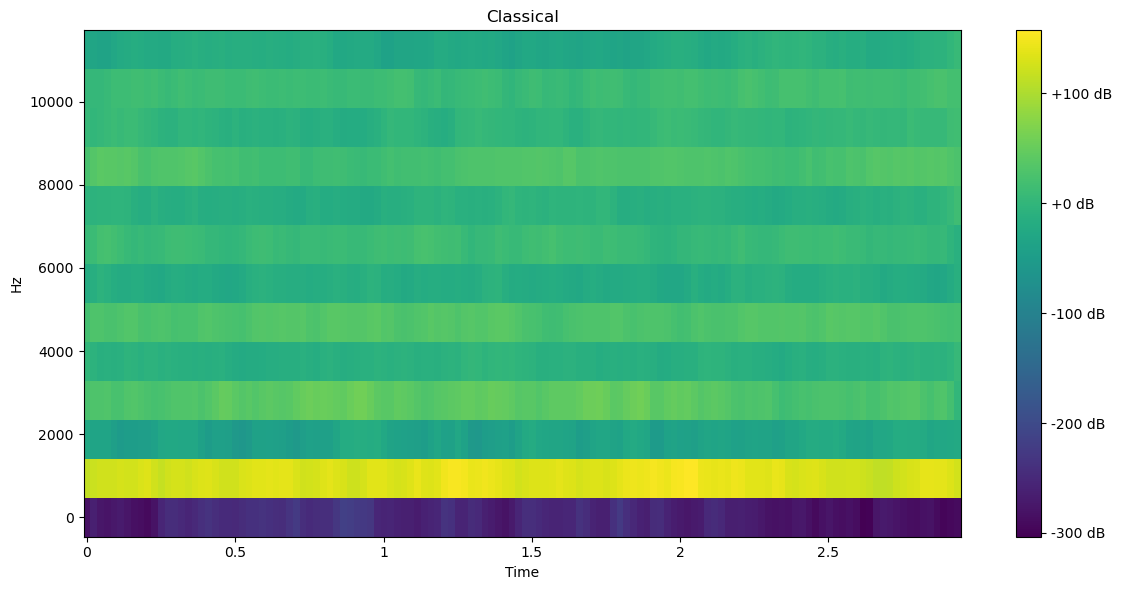

In [4]:
# Plot MFCC example to ensure data was imported properly
idx = 1000
fs = 22500
plot_mfcc(np.array(data["mfcc"])[idx].T, fs)
plt.title(f"{np.array(data['genre_name'])[idx].title()}");

## Modeling
- Two types of models were tested
    - Dense Neural Network (DNN)
    - Convolutional Neural Network (CNN)
- For audio and image classification, CNNs typically outperform DNNs. Our testing confirmed this, so we worked with the CNN to improve its performance through parameter tuning and regularization techniques.
- Additionally, data needs to be in the correct "shape" in order to input into certain models.
    - DNN: (n, n)
    - CNN: (n, n, 1)
- Data is also split into 3 sets
    - Training set: For the model to train on
    - Validation set: For the model to compare against while training
    - Test set: A set unsees by the model until the end for final testing

In [5]:
# Define X nd y
X = np.array(data["mfcc"])
y = np.array(data["genre_num"])

In [6]:
# Train-validation-test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

# shape = (# samples, time-bins (x), num MFCCs (y))
print(f"X training data shape: {X_train.shape}, y training data shape: {y_train.shape}")
print(f"X validation data shape: {X_val.shape}, y validation data shape: {y_val.shape}")

X training data shape: (4893, 130, 13), y training data shape: (4893,)
X validation data shape: (2097, 130, 13), y validation data shape: (2097,)


In [7]:
def plot_history(hist):
    """Plots the accuracy and loss for a model over the course of all epochs
    
    Parameters:
        hist (keras history object): The recorded history of model.fit() to be plotted
    """
    fig, axs = plt.subplots(2, 1, figsize=(8,7))
    fig.tight_layout(pad=2)
    
    # Accuracy subplot
    axs[0].plot(hist.history["acc"], c='navy', label="Training Accuracy")
    axs[0].plot(hist.history["val_acc"], c='orange', label="Validation Accuracy")    
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy")
    
    # Error subplot
    axs[1].plot(hist.history["loss"], c='navy', label="Training Loss")
    axs[1].plot(hist.history["val_loss"], c='orange', label="Validation Loss")    
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epochs")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss")
    
    plt.show()

### Dense Neural Network (DNN)
- A Dense Neural Network consists of multiple dense layers ordered sequentially one after the other.
- An 'l2' regularization penalty was leveraged to help mitigate overfitting.
- Dropout layers were included to help mitigate overfitting.
- Dense neural networks are useful for some tasks, but often do not perform as well on image and audio data.

In [8]:
# Dense Neural Network

# Instantiate sequential model
model_dnn = Sequential()

# Flatten to dense
model_dnn.add(Flatten(input_shape=(X.shape[1:3])))

# Create Dense Layers
model_dnn.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model_dnn.add(Dropout(0.3))
model_dnn.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model_dnn.add(Dropout(0.3))
model_dnn.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model_dnn.add(Dropout(0.3))
model_dnn.add(Dense(10, activation='softmax'))

In [9]:
# Review model structure
model_dnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1690)              0         
                                                                 
 dense (Dense)               (None, 512)               865792    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

In [10]:
# Compile
model_dnn.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy', # loss for multi-class classification
    metrics=['acc']
)

In [11]:
# Train the model
hist_dnn = model_dnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=250,
    verbose=1
)

Epoch 1/250
77/77 [==============================] - 2s 17ms/step - loss: 44.5291 - acc: 0.1420 - val_loss: 4.4734 - val_acc: 0.2527
Epoch 2/250
77/77 [==============================] - 1s 13ms/step - loss: 12.8623 - acc: 0.1721 - val_loss: 3.5847 - val_acc: 0.1960
Epoch 3/250
77/77 [==============================] - 1s 13ms/step - loss: 8.0842 - acc: 0.1535 - val_loss: 3.5063 - val_acc: 0.1354
Epoch 4/250
77/77 [==============================] - 1s 13ms/step - loss: 5.7192 - acc: 0.1498 - val_loss: 3.4887 - val_acc: 0.1259
Epoch 5/250
77/77 [==============================] - 1s 13ms/step - loss: 4.9934 - acc: 0.1337 - val_loss: 3.4959 - val_acc: 0.1206
Epoch 6/250
77/77 [==============================] - 1s 18ms/step - loss: 4.3971 - acc: 0.1349 - val_loss: 3.5017 - val_acc: 0.1149
Epoch 7/250
77/77 [==============================] - 1s 14ms/step - loss: 4.0395 - acc: 0.1363 - val_loss: 3.4995 - val_acc: 0.1168
Epoch 8/250
77/77 [==============================] - 1s 15ms/step - loss: 

77/77 [==============================] - 1s 13ms/step - loss: 1.8068 - acc: 0.5784 - val_loss: 2.1900 - val_acc: 0.5227
Epoch 124/250
77/77 [==============================] - 1s 13ms/step - loss: 1.7964 - acc: 0.5800 - val_loss: 2.2372 - val_acc: 0.5246
Epoch 125/250
77/77 [==============================] - 1s 13ms/step - loss: 1.7800 - acc: 0.5792 - val_loss: 2.1896 - val_acc: 0.5312
Epoch 126/250
77/77 [==============================] - 1s 12ms/step - loss: 1.7799 - acc: 0.5829 - val_loss: 2.1921 - val_acc: 0.5150
Epoch 127/250
77/77 [==============================] - 1s 12ms/step - loss: 1.7389 - acc: 0.5896 - val_loss: 2.2293 - val_acc: 0.5360
Epoch 128/250
77/77 [==============================] - 1s 12ms/step - loss: 1.7183 - acc: 0.5953 - val_loss: 2.2280 - val_acc: 0.5269
Epoch 129/250
77/77 [==============================] - 1s 13ms/step - loss: 1.7095 - acc: 0.5984 - val_loss: 2.1963 - val_acc: 0.5265
Epoch 130/250
77/77 [==============================] - 1s 13ms/step - loss: 

77/77 [==============================] - 1s 13ms/step - loss: 0.7512 - acc: 0.8588 - val_loss: 2.2865 - val_acc: 0.5885
Epoch 246/250
77/77 [==============================] - 1s 13ms/step - loss: 0.7101 - acc: 0.8712 - val_loss: 2.2283 - val_acc: 0.5894
Epoch 247/250
77/77 [==============================] - 1s 13ms/step - loss: 0.7143 - acc: 0.8757 - val_loss: 2.2459 - val_acc: 0.5928
Epoch 248/250
77/77 [==============================] - 1s 13ms/step - loss: 0.7237 - acc: 0.8712 - val_loss: 2.1716 - val_acc: 0.5870
Epoch 249/250
77/77 [==============================] - 1s 13ms/step - loss: 0.6924 - acc: 0.8782 - val_loss: 2.3456 - val_acc: 0.5861
Epoch 250/250
77/77 [==============================] - 1s 14ms/step - loss: 0.7087 - acc: 0.8712 - val_loss: 2.3087 - val_acc: 0.5861


In [12]:
loss_dnn, acc_dnn = model_dnn.evaluate(X_test, y_test)
print(f"Test Loss: {loss_dnn}")
print(f"Test Accuracy: {acc_dnn}")

94/94 [==============================] - 0s 4ms/step - loss: 2.4151 - acc: 0.5778
Test Loss: 2.4150619506835938
Test Accuracy: 0.5777703523635864


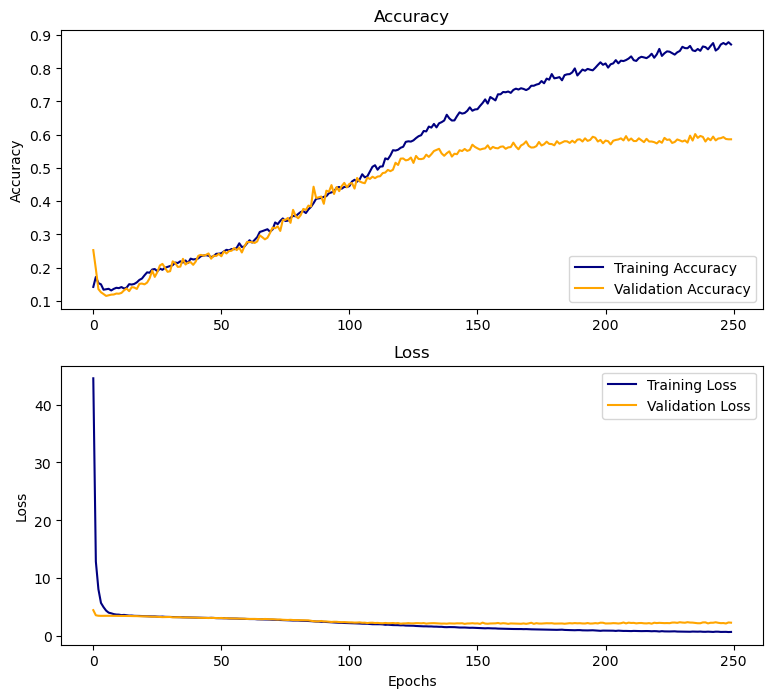

In [13]:
plot_history(hist_dnn)

### Convolutional Neural Network (Without Regularization)
- A Convolutional Neural Network (CNN) consists of a combination of convolution layers and dense layers.
- Convolution layers first begin to identify features within the data, similar to edge detection in image data.
- The the data is flattened out to run through dense layers to classify the data.
- A base CNN was tested without regulatization methods to establish a base performance before iterating through tuning parameters.

In [14]:
# Add additional dimension for CNN
X_train_cnn = X_train[..., np.newaxis]
X_val_cnn = X_val[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

input_shape = X_train_cnn.shape[1:4]
X_train_cnn.shape # shape = (# samples, time-bins (x), num MFCCs (y), "channel" (like an image))

(4893, 130, 13, 1)

In [15]:
# Convolutional Neural Network - Original

# Instantiate sequential model
model_cnn1 = Sequential()

# Create a convolution block
model_cnn1.add(Conv2D(32, 3, activation='relu', input_shape=input_shape)) # first hidden conv layer
model_cnn1.add(MaxPooling2D(3, strides=(2,2), padding='same')) # MaxPool the results

# Add another conv block
model_cnn1.add(Conv2D(64, 3, activation='relu'))
model_cnn1.add(MaxPooling2D(3, strides=(2,2), padding='same'))

# Add another conv block
model_cnn1.add(Conv2D(64, 2, activation='relu'))
model_cnn1.add(MaxPooling2D(2, strides=(2,2), padding='same'))

# Flatten output to send through dense layers
model_cnn1.add(Flatten())
model_cnn1.add(Dense(64, activation='relu'))

# output to 10 classes for predictions
model_cnn1.add(Dense(10, activation='softmax')) # Softmax activation for multi-class classification

In [16]:
model_cnn1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 6, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 4, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 2, 64)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 1, 64)         16448     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 1, 64)       

In [17]:
model_cnn1.compile(
    optimizer=Adam(learning_rate=0.0001), # can also use 'adam'
    loss='sparse_categorical_crossentropy', # loss for multi-class classification
    metrics=['acc']
)

In [18]:
%%time
# Train the model
hist_cnn1 = model_cnn1.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    batch_size=64,
    epochs=250,
    verbose=1
)

Epoch 1/250
77/77 [==============================] - 5s 55ms/step - loss: 3.4859 - acc: 0.1862 - val_loss: 1.9909 - val_acc: 0.3038
Epoch 2/250
77/77 [==============================] - 4s 48ms/step - loss: 1.8365 - acc: 0.3585 - val_loss: 1.7413 - val_acc: 0.3939
Epoch 3/250
77/77 [==============================] - 4s 48ms/step - loss: 1.6287 - acc: 0.4210 - val_loss: 1.6218 - val_acc: 0.4268
Epoch 4/250
77/77 [==============================] - 4s 46ms/step - loss: 1.5035 - acc: 0.4541 - val_loss: 1.5572 - val_acc: 0.4354
Epoch 5/250
77/77 [==============================] - 4s 47ms/step - loss: 1.4097 - acc: 0.4878 - val_loss: 1.4734 - val_acc: 0.4688
Epoch 6/250
77/77 [==============================] - 4s 47ms/step - loss: 1.3243 - acc: 0.5207 - val_loss: 1.4184 - val_acc: 0.4797
Epoch 7/250
77/77 [==============================] - 4s 47ms/step - loss: 1.2605 - acc: 0.5428 - val_loss: 1.3934 - val_acc: 0.4988
Epoch 8/250
77/77 [==============================] - 4s 47ms/step - loss: 1.

77/77 [==============================] - 4s 49ms/step - loss: 0.0076 - acc: 0.9994 - val_loss: 1.6182 - val_acc: 0.6929
Epoch 124/250
77/77 [==============================] - 4s 46ms/step - loss: 0.0088 - acc: 0.9988 - val_loss: 1.7077 - val_acc: 0.6838
Epoch 125/250
77/77 [==============================] - 4s 46ms/step - loss: 0.0083 - acc: 0.9992 - val_loss: 1.6370 - val_acc: 0.6948
Epoch 126/250
77/77 [==============================] - 4s 46ms/step - loss: 0.0087 - acc: 0.9992 - val_loss: 1.6837 - val_acc: 0.6857
Epoch 127/250
77/77 [==============================] - 4s 47ms/step - loss: 0.0093 - acc: 0.9988 - val_loss: 1.6676 - val_acc: 0.6948
Epoch 128/250
77/77 [==============================] - 4s 46ms/step - loss: 0.0079 - acc: 0.9990 - val_loss: 1.7030 - val_acc: 0.6958
Epoch 129/250
77/77 [==============================] - 4s 47ms/step - loss: 0.0082 - acc: 0.9990 - val_loss: 1.7147 - val_acc: 0.6929
Epoch 130/250
77/77 [==============================] - 4s 47ms/step - loss: 

77/77 [==============================] - 4s 47ms/step - loss: 0.0067 - acc: 0.9988 - val_loss: 1.8909 - val_acc: 0.6929
Epoch 246/250
77/77 [==============================] - 4s 47ms/step - loss: 0.0035 - acc: 0.9992 - val_loss: 1.8654 - val_acc: 0.6924
Epoch 247/250
77/77 [==============================] - 4s 47ms/step - loss: 0.0037 - acc: 0.9990 - val_loss: 1.8885 - val_acc: 0.6958
Epoch 248/250
77/77 [==============================] - 4s 48ms/step - loss: 0.0029 - acc: 0.9992 - val_loss: 1.8813 - val_acc: 0.6958
Epoch 249/250
77/77 [==============================] - 4s 48ms/step - loss: 0.0032 - acc: 0.9990 - val_loss: 1.9056 - val_acc: 0.6981
Epoch 250/250
77/77 [==============================] - 4s 48ms/step - loss: 0.0027 - acc: 0.9992 - val_loss: 1.8987 - val_acc: 0.6962
CPU times: total: 1h 42min 1s
Wall time: 15min 11s


In [19]:
loss_cnn1, acc_cnn1 = model_cnn1.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss_cnn1}")
print(f"Test Accuracy: {acc_cnn1}")

94/94 [==============================] - 1s 11ms/step - loss: 1.9595 - acc: 0.6919
Test Loss: 1.959450364112854
Test Accuracy: 0.6919225454330444


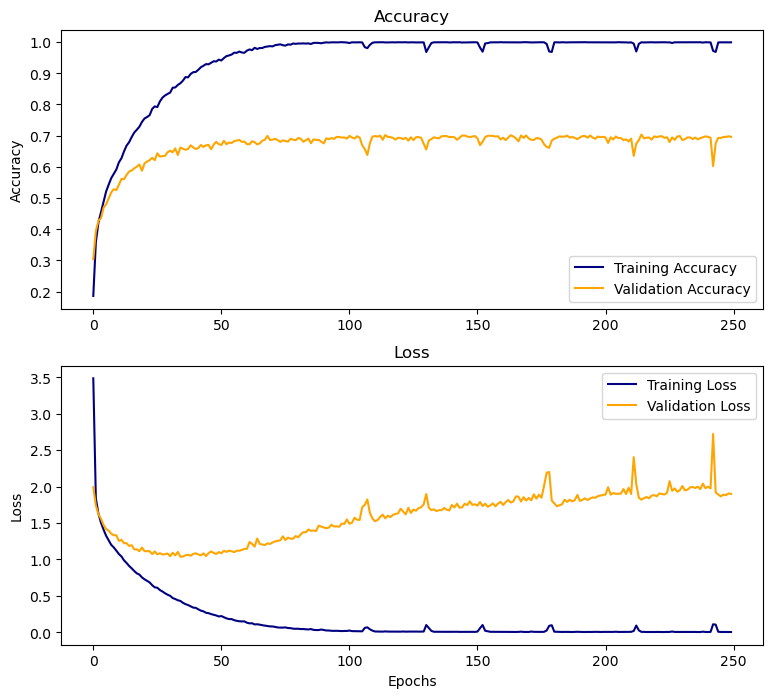

In [20]:
plot_history(hist_cnn1)

### Convolutional Neural Network (With Regularization)
- A Convolutional Neural Network (CNN) consists of a combination of convolution layers and dense layers.
- Convolution layers first begin to identify features within the data, similar to edge detection in image data.
- The the data is flattened out to run through dense layers to classify the data.
- The CNN below went through many iterations to tune regularization parameters. We included:
    - Dropout: Drops some nodes through each epoch to force all nodes to learn all features of the model. This helps reduce overfitting of the model.
    - Early Stopping: This stops the model once it has reached a certain threshold of no longer improving. This also helps reduce overfitting.
    - Regularization penalties (such as 'l2') were *not* leveraged for the CNN, as they do not improve the performance of the model.

In [21]:
# Convolutional Neural Network - BEST

# Instantiate sequential model
model_cnn2 = Sequential()

# Create a convolution block
model_cnn2.add(Conv2D(32, 3, activation='relu', input_shape=input_shape)) # first hidden conv layer
model_cnn2.add(BatchNormalization())
model_cnn2.add(MaxPooling2D(3, strides=(2,2), padding='same')) # MaxPool the results
model_cnn2.add(Dropout(0.2))

# Add another conv block
model_cnn2.add(Conv2D(64, 3, activation='relu'))
model_cnn2.add(BatchNormalization())
model_cnn2.add(MaxPooling2D(3, strides=(2,2), padding='same'))
model_cnn2.add(Dropout(0.1))

# Add another conv block
model_cnn2.add(Conv2D(64, 2, activation='relu'))
model_cnn2.add(BatchNormalization())
model_cnn2.add(MaxPooling2D(2, strides=(2,2), padding='same'))
model_cnn2.add(Dropout(0.1))

# Flatten output to send through dense layers
model_cnn2.add(Flatten())
model_cnn2.add(Dense(128, activation='relu'))
model_cnn2.add(Dropout(0.5))

# output to 10 classes for predictions
model_cnn2.add(Dense(10, activation='softmax')) # Softmax activation for multi-class classification

In [22]:
model_cnn2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 11, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 128, 11, 32)      128       
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 6, 32)        0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 64, 6, 32)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 62, 4, 64)         18496     
                                                                 
 batch_normalization_1 (Batc  (None, 62, 4, 64)       

In [23]:
model_cnn2.compile(
    optimizer=Adam(learning_rate=0.0001), # can also use 'adam'
    loss='sparse_categorical_crossentropy', # loss for multi-class classification
    metrics=['acc']
)

In [24]:
# Create an early stopping callback
es_cnn2 = EarlyStopping(monitor='val_loss', patience=20, min_delta=0) 

In [25]:
%%time
# Train the model
hist_cnn2 = model_cnn2.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    batch_size=64,
    epochs=250,
    verbose=1
#     callbacks=[es_cnn2]
)

Epoch 1/250
77/77 [==============================] - 8s 73ms/step - loss: 3.2659 - acc: 0.1512 - val_loss: 2.1595 - val_acc: 0.2155
Epoch 2/250
77/77 [==============================] - 5s 67ms/step - loss: 2.4897 - acc: 0.2440 - val_loss: 1.9228 - val_acc: 0.2890
Epoch 3/250
77/77 [==============================] - 5s 65ms/step - loss: 2.1897 - acc: 0.2904 - val_loss: 1.7881 - val_acc: 0.3371
Epoch 4/250
77/77 [==============================] - 5s 67ms/step - loss: 1.9801 - acc: 0.3358 - val_loss: 1.7935 - val_acc: 0.3553
Epoch 5/250
77/77 [==============================] - 5s 67ms/step - loss: 1.8383 - acc: 0.3713 - val_loss: 1.7622 - val_acc: 0.3863
Epoch 6/250
77/77 [==============================] - 5s 67ms/step - loss: 1.7417 - acc: 0.3881 - val_loss: 1.7272 - val_acc: 0.4163
Epoch 7/250
77/77 [==============================] - 5s 66ms/step - loss: 1.6343 - acc: 0.4288 - val_loss: 1.6568 - val_acc: 0.4373
Epoch 8/250
77/77 [==============================] - 5s 71ms/step - loss: 1.

77/77 [==============================] - 5s 59ms/step - loss: 0.4048 - acc: 0.8543 - val_loss: 0.8853 - val_acc: 0.7544
Epoch 124/250
77/77 [==============================] - 5s 64ms/step - loss: 0.4174 - acc: 0.8492 - val_loss: 0.8218 - val_acc: 0.7697
Epoch 125/250
77/77 [==============================] - 5s 62ms/step - loss: 0.3942 - acc: 0.8563 - val_loss: 0.9023 - val_acc: 0.7477
Epoch 126/250
77/77 [==============================] - 5s 60ms/step - loss: 0.3983 - acc: 0.8588 - val_loss: 0.8457 - val_acc: 0.7620
Epoch 127/250
77/77 [==============================] - 5s 63ms/step - loss: 0.3948 - acc: 0.8553 - val_loss: 0.8446 - val_acc: 0.7654
Epoch 128/250
77/77 [==============================] - 5s 61ms/step - loss: 0.3674 - acc: 0.8678 - val_loss: 0.9033 - val_acc: 0.7477
Epoch 129/250
77/77 [==============================] - 4s 56ms/step - loss: 0.3848 - acc: 0.8596 - val_loss: 0.9022 - val_acc: 0.7449
Epoch 130/250
77/77 [==============================] - 5s 60ms/step - loss: 

77/77 [==============================] - 5s 61ms/step - loss: 0.1775 - acc: 0.9373 - val_loss: 0.8048 - val_acc: 0.8045
Epoch 246/250
77/77 [==============================] - 5s 60ms/step - loss: 0.1772 - acc: 0.9373 - val_loss: 0.7828 - val_acc: 0.8116
Epoch 247/250
77/77 [==============================] - 5s 61ms/step - loss: 0.1678 - acc: 0.9411 - val_loss: 0.7999 - val_acc: 0.8073
Epoch 248/250
77/77 [==============================] - 5s 60ms/step - loss: 0.1769 - acc: 0.9409 - val_loss: 0.7970 - val_acc: 0.8021
Epoch 249/250
77/77 [==============================] - 5s 60ms/step - loss: 0.1880 - acc: 0.9336 - val_loss: 0.7620 - val_acc: 0.8145
Epoch 250/250
77/77 [==============================] - 5s 60ms/step - loss: 0.1661 - acc: 0.9413 - val_loss: 0.7517 - val_acc: 0.8164
CPU times: total: 2h 19min 31s
Wall time: 19min 41s


In [26]:
loss_cnn2, acc_cnn2 = model_cnn2.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss_cnn2}")
print(f"Test Accuracy: {acc_cnn2}")

94/94 [==============================] - 1s 10ms/step - loss: 0.7806 - acc: 0.8007
Test Loss: 0.7806130051612854
Test Accuracy: 0.8007343411445618


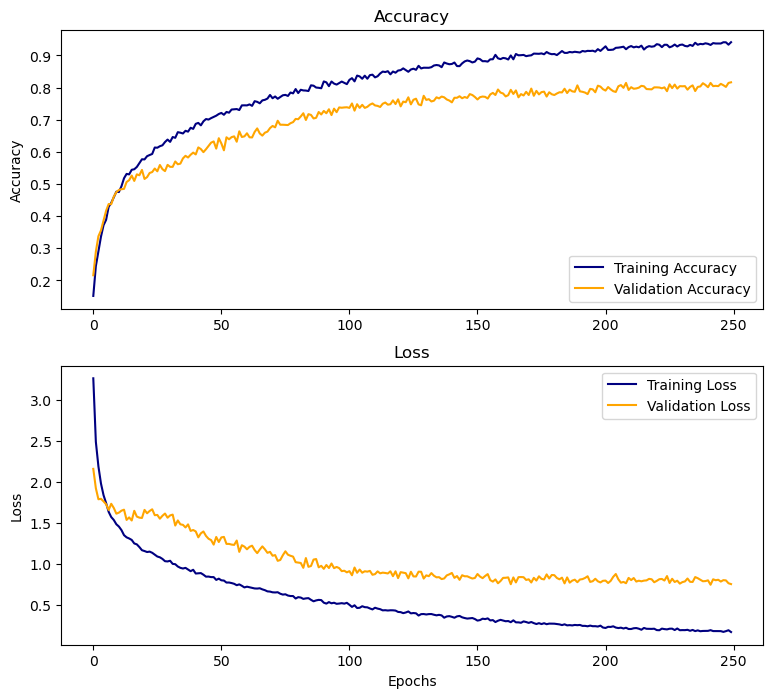

In [27]:
plot_history(hist_cnn2)

### Convolutional Neural Network (With Regularization and Data Augmentation)
- This model is exactly the same as the previous CNN with regularization techniques implemented, with an addition of a data augmentation technique.
- Because the audio data has essentially been transcoded into something similar to an image, flipping the "image" can effectively add more diverse data for the model to train on. This flipping is analogous to feeding the audio clip through the model in reverse.
- Adding this diversity in data can improve the model without having to truly provide it more data.

In [28]:
# Convolutional Neural Network - BEST

# Instantiate sequential model
model_cnn3 = Sequential()

# Create a convolution block
model_cnn3.add(Conv2D(32, 3, activation='relu', input_shape=input_shape)) # first hidden conv layer
model_cnn3.add(BatchNormalization())
model_cnn3.add(MaxPooling2D(3, strides=(2,2), padding='same')) # MaxPool the results
model_cnn3.add(Dropout(0.2))

# Add another conv block
model_cnn3.add(Conv2D(64, 3, activation='relu'))
model_cnn3.add(BatchNormalization())
model_cnn3.add(MaxPooling2D(3, strides=(2,2), padding='same'))
model_cnn3.add(Dropout(0.1))

# Add another conv block
model_cnn3.add(Conv2D(64, 2, activation='relu'))
model_cnn3.add(BatchNormalization())
model_cnn3.add(MaxPooling2D(2, strides=(2,2), padding='same'))
model_cnn3.add(Dropout(0.1))

# Flatten output to send through dense layers
model_cnn3.add(Flatten())
model_cnn3.add(Dense(128, activation='relu'))
model_cnn3.add(Dropout(0.5))

# output to 10 classes for predictions
model_cnn3.add(Dense(10, activation='softmax')) # Softmax activation for multi-class classification

In [29]:
model_cnn3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 11, 32)       320       
                                                                 
 batch_normalization_3 (Batc  (None, 128, 11, 32)      128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 6, 32)        0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 64, 6, 32)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 62, 4, 64)         18496     
                                                                 
 batch_normalization_4 (Batc  (None, 62, 4, 64)       

In [30]:
model_cnn3.compile(
    optimizer=Adam(learning_rate=0.0001), # can also use 'adam'
    loss='sparse_categorical_crossentropy', # loss for multi-class classification
    metrics=['acc']
)

In [31]:
# Datagen
datagen = ImageDataGenerator(vertical_flip=True)

In [32]:
# Create an early stopping callback
es_cnn3 = EarlyStopping(monitor='val_loss', patience=20, min_delta=0) 

In [33]:
%%time
# Train the model
hist_cnn3 = model_cnn3.fit(
    datagen.flow(X_train_cnn, y_train),
    validation_data=(X_val_cnn, y_val),
    batch_size=64,
    epochs=400,
    verbose=1
#     callbacks=[es_cnn]
)

Epoch 1/400
153/153 [==============================] - 7s 38ms/step - loss: 3.0856 - acc: 0.1815 - val_loss: 2.0690 - val_acc: 0.2723
Epoch 2/400
153/153 [==============================] - 5s 36ms/step - loss: 2.3392 - acc: 0.2730 - val_loss: 2.0351 - val_acc: 0.3271
Epoch 3/400
153/153 [==============================] - 5s 35ms/step - loss: 1.9801 - acc: 0.3382 - val_loss: 2.0473 - val_acc: 0.3562
Epoch 4/400
153/153 [==============================] - 5s 35ms/step - loss: 1.8107 - acc: 0.3744 - val_loss: 1.9755 - val_acc: 0.3882
Epoch 5/400
153/153 [==============================] - 5s 35ms/step - loss: 1.6995 - acc: 0.3963 - val_loss: 1.9372 - val_acc: 0.4211
Epoch 6/400
153/153 [==============================] - 5s 35ms/step - loss: 1.6303 - acc: 0.4169 - val_loss: 2.0093 - val_acc: 0.4258
Epoch 7/400
153/153 [==============================] - 5s 35ms/step - loss: 1.5473 - acc: 0.4459 - val_loss: 1.8433 - val_acc: 0.4516
Epoch 8/400
153/153 [==============================] - 5s 35ms

Epoch 62/400
153/153 [==============================] - 5s 35ms/step - loss: 0.7373 - acc: 0.7372 - val_loss: 1.0692 - val_acc: 0.6910
Epoch 63/400
153/153 [==============================] - 5s 35ms/step - loss: 0.7178 - acc: 0.7525 - val_loss: 1.0483 - val_acc: 0.6853
Epoch 64/400
153/153 [==============================] - 5s 35ms/step - loss: 0.7265 - acc: 0.7406 - val_loss: 1.0344 - val_acc: 0.7000
Epoch 65/400
153/153 [==============================] - 5s 35ms/step - loss: 0.7273 - acc: 0.7370 - val_loss: 1.1293 - val_acc: 0.6876
Epoch 66/400
153/153 [==============================] - 5s 35ms/step - loss: 0.7288 - acc: 0.7349 - val_loss: 0.9288 - val_acc: 0.7229
Epoch 67/400
153/153 [==============================] - 5s 35ms/step - loss: 0.7113 - acc: 0.7503 - val_loss: 1.0134 - val_acc: 0.7029
Epoch 68/400
153/153 [==============================] - 5s 35ms/step - loss: 0.7099 - acc: 0.7466 - val_loss: 0.9670 - val_acc: 0.7034
Epoch 69/400
153/153 [==============================] -

153/153 [==============================] - 5s 35ms/step - loss: 0.3637 - acc: 0.8616 - val_loss: 0.6975 - val_acc: 0.8078
Epoch 183/400
153/153 [==============================] - 5s 35ms/step - loss: 0.3566 - acc: 0.8725 - val_loss: 0.7238 - val_acc: 0.8040
Epoch 184/400
153/153 [==============================] - 5s 35ms/step - loss: 0.3491 - acc: 0.8725 - val_loss: 0.6663 - val_acc: 0.8188
Epoch 185/400
153/153 [==============================] - 5s 35ms/step - loss: 0.3542 - acc: 0.8704 - val_loss: 0.7371 - val_acc: 0.8026
Epoch 186/400
153/153 [==============================] - 5s 35ms/step - loss: 0.3545 - acc: 0.8755 - val_loss: 0.7200 - val_acc: 0.8064
Epoch 187/400
153/153 [==============================] - 5s 35ms/step - loss: 0.3314 - acc: 0.8809 - val_loss: 0.6906 - val_acc: 0.8164
Epoch 188/400
153/153 [==============================] - 5s 35ms/step - loss: 0.3534 - acc: 0.8712 - val_loss: 0.7322 - val_acc: 0.8116
Epoch 189/400
153/153 [==============================] - 5s 36

153/153 [==============================] - 6s 36ms/step - loss: 0.2271 - acc: 0.9213 - val_loss: 0.6614 - val_acc: 0.8298
Epoch 303/400
153/153 [==============================] - 5s 35ms/step - loss: 0.2230 - acc: 0.9219 - val_loss: 0.6800 - val_acc: 0.8250
Epoch 304/400
153/153 [==============================] - 5s 35ms/step - loss: 0.2145 - acc: 0.9191 - val_loss: 0.7121 - val_acc: 0.8202
Epoch 305/400
153/153 [==============================] - 5s 35ms/step - loss: 0.2102 - acc: 0.9266 - val_loss: 0.7748 - val_acc: 0.8140
Epoch 306/400
153/153 [==============================] - 5s 34ms/step - loss: 0.2233 - acc: 0.9199 - val_loss: 0.7354 - val_acc: 0.8178
Epoch 307/400
153/153 [==============================] - 5s 35ms/step - loss: 0.2312 - acc: 0.9166 - val_loss: 0.6899 - val_acc: 0.8317
Epoch 308/400
153/153 [==============================] - 5s 34ms/step - loss: 0.2101 - acc: 0.9262 - val_loss: 0.6751 - val_acc: 0.8293
Epoch 309/400
153/153 [==============================] - 5s 35

In [34]:
loss_cnn3, acc_cnn3 = model_cnn3.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss_cnn3}")
print(f"Test Accuracy: {acc_cnn3}")

94/94 [==============================] - 1s 10ms/step - loss: 0.6343 - acc: 0.8381
Test Loss: 0.6343286037445068
Test Accuracy: 0.8381174802780151


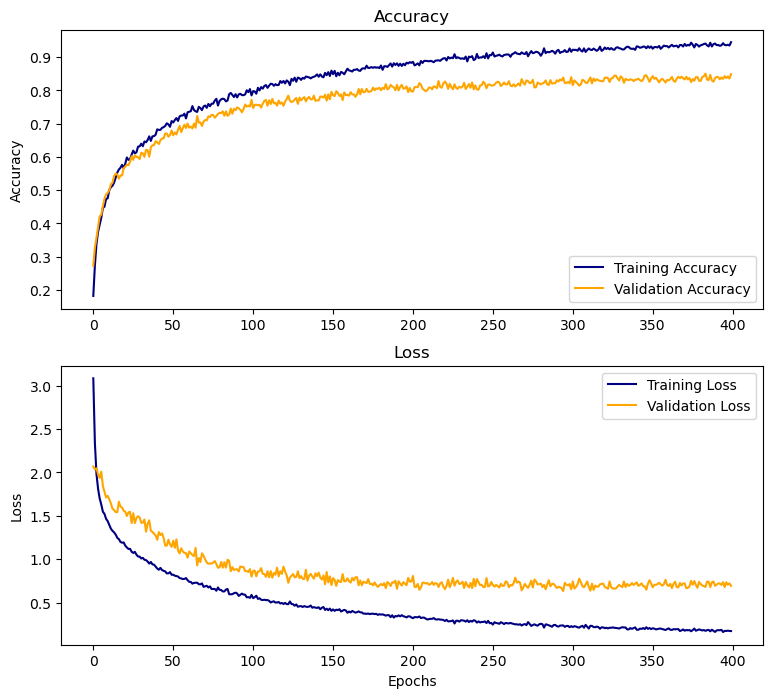

In [35]:
plot_history(hist_cnn3)

### Save Models
- Save the model to disk to allow for later predictions

In [36]:
model_dnn.save('../models/model_dnn.h5')
model_cnn1.save('../models/model_cnn1.h5')
model_cnn2.save('../models/model_cnn2.h5')
model_cnn3.save('../models/model_cnn3.h5')

### Make Predictions
- Make predictions on the "test" dataset that the model has not seen yet. This simulates how well the model has been generalized (i.e. can perform on new data).

In [37]:
def make_prediction(model, X):
    """Makes predictions given a keras model and a set of data.
    
    Parameters:
        model (keras model): The model to use to make predictions
        X (np.sdarray): Testing data to be fed into the model to make predictions with.
        
    Returns:
        preds_num (list): List of genre predictions (number format, 0-9)
        preds_name (list): List of genre predictions (str format)
    """
    genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
    preds_num = []
    preds_name = []

    for X_current in X:
        X_current = X_current[np.newaxis, ...]
        pred = model.predict(X_current)
        pred = np.argmax(pred, axis=1) # predicted index
        preds_num.append(pred[0])
        preds_name.append(genres[pred[0]])
        
    return preds_num, preds_name

In [38]:
%%time
# Make predictions - Takes ~10 min to run
preds_num, preds_name = make_prediction(model_cnn3, X_test_cnn)

1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 54ms/step
CPU times: total: 58min 7s
Wall time: 9min 8s


In [39]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, preds_num)

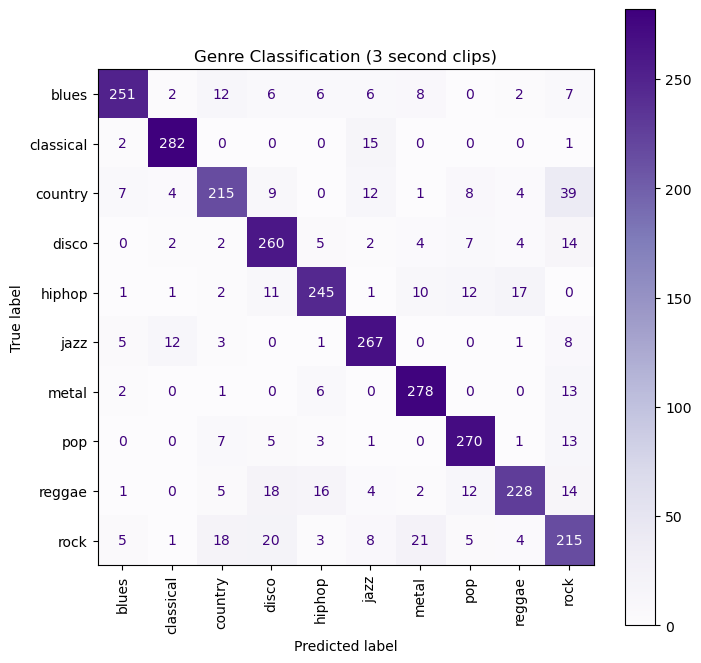

In [40]:
# Plot confusion matrix for review
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
fig, ax = plt.subplots(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=genres)
disp.plot(ax=ax, cmap = 'Purples', xticks_rotation='vertical')
plt.title('Genre Classification (3 second clips)');

## Conclusions & Recommendations

### Model Performance Summary
Below are the final performance metrics for all models that were tested.
*NOTE:* All models were overfit, as is common with neural networks. We worked to balance overfitting the model with performance to ensure optimal performance on unseen data.

|**Model**|**Accuracy**|
|---|---|
|**DNN**|0.578|
|**CNN (Without Regularization)**|0.691|
|**CNN (With Regularization)**|0.801|
|**CNN (With Regularization and Data Manipulation)**|0.838|

### Conclusions

#### Audio Modeling Conclusions
In this notebook, 4 separate neural networks were trained:
1. Dense Neural Network (DNN)
2. Convolutional Neural Network (CNN)
3. Convolutional Neural Network with Regularization
4. Convolutional Neural Network with Regularization and Data Augmentation

A Dense neural network was tested as it is one of the simplest types of neural networks and is comparatively fast to train. However, when working with data such as this (audio or images), DNNs typically do not perform quite as well as CNNs due to their structure. So while a reasonable model can be created using a DNN, it does not perform as optimally as a CNN.

Convolutional neural networks were trained and iterated upon as they often perform better on audio and image data. Because we essentially transformed our audio data into something similar to an image, a CNN was the best choice for this dataset. We began with a base CNN structure and then continued adding features to improve the model. In addition to the base CNN, we added the regularization method of "dropout", which randomly drops nodes from the network to force each node to learn more broadly, ultimately reducing overfitting and improving generalized performance. Additionally, because the audio data has been transformed into something similar to an image, flipping this audio "image" (a.k.a. sending the audio through the model in reverse), diversifies the data the model was learning on. Each of these steps improved our performance.

Overall, the final CNN model has proven the ability to learn complex patterns in the audio features that are relevant for music genre classification. To allow for such an accurate performance, audio needs to be transformed into the appropriate format that works best with CNNs. This means that the audio must be transformed into what is similar to an image, like a "picture of audio".

#### Project Conclusions
Through these technical notebook reports, audio data was collected, processed, and used to train multiple classification models. Additionally, engineered audio feature data was scraped from Spotify to use in another classification model. These two separate methods were performed to demonstrate the different ways songs can be classified into genres of music.
- Utilizing pre-engineered features provided by Spotify, such as Liveness, Acousticness, Tempo, etc. to train a logistic regression and dense neural network model.
- Processing raw audio files to train a dense neural network and multiple convolutional neural networks.

Both methods have pros and cons.

The benefit of modeling using pre-engineered data is that the data is organized, can be easily manipulated, and the models require less time to train before predictions. Additionally, other types of models can be trained on tabular data such as this. However, performance sometimes can suffer when using pre-engineered features that you do not quite have a full understanding of how they were created. Additionally, it takes a significant amount of resources from Spotify to calculate these engineered features for every song.

The benefit of modeling with raw audio is that you have access to the source data and full control over how it can be manipulated. This leads to mode a more flexible model that can be fed any piece of audio and still attempt to classify it. Some drawbacks to this method though are there is more effort, computation, and knowledge required to process the audio data appropriately and models also take longer to train on this data type.

While both methods have their pros and cons, the final model presented in this notebook demonstrates that this method of audio processing and modeling is an effective means of audio classification.

### Recommendations

Based on our achievements in this model, outperforming models trained on Spotify's engineered audio features, we recommend that Spotify allocate more funding to further develop this convolutional neural network classification technology. Resources should be distributed to collect larger and more diverse data sets as well as continue to refine and improve the current model. In addition to classifying smaller or independent artists, this technology also could be leveraged for recommendation systems to generate playlists with similar artists or recommend new artists to users.

The following are some additional areas for potential improvement:
- Further optimizing hyperparameters such as the learning rate, batch size, and number of epochs
- Test different lengths of audio to train the model (i.e. 2 sec, 5 sec, 10 sec,). This model used 3 sec.
- Implement additional data augmentation techniques to increase the diversity of the training data
- Collect more data for the model to train on.